Here, we redefine the aimc value based on the original Park & Choi (2005) definition of the early type galaxies in the color - color-gradient space:

\begin{equation}
  \text{aimc} = \tan^{-1} \left( \frac{-\Delta (g-i) + 0.3}{(u-r) - 1} \right) + 90^\circ
\end{equation}

We also redefine the $c_{inv}$ cut based on skew-normal fits to the $c_{inv}$ distributions for each magnitude bin.

In [1]:
from astropy.table import Table, vstack

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data import

In [2]:
#galaxy_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_correctVflag.txt'
galaxy_filename = '/Users/kellydouglass/Documents/Research/data/NSA_v1_0_1_VAGC.fits'

#galaxies = Table.read(galaxy_filename, format='ascii.commented_header')
galaxies = Table.read(galaxy_filename, format='fits')

## Replace all invalid colors, color gradients with NaNs

In [13]:
galaxies['cd'][galaxies['cd'] == -99] = np.nan
galaxies['u_r_KIAS'][galaxies['u_r_KIAS'] == -99] = np.nan

# Calculate aimc

In [6]:
def my_aimc_vertical(grad, color):
    
    grad_shift = 0.3
    color_shift = -1
    
    aimc = np.arctan2(-grad + grad_shift, color + color_shift) + 0.5*np.pi
    
    # Need to convert from radians to degrees
    aimc = aimc*180/np.pi
    
    # Need to map [-180,0) to [180,360)
    aimc[aimc < 0] += 360
    
    return aimc

In [15]:
galaxies['my_aimc'] = my_aimc_vertical(galaxies['cd'], galaxies['u_r_KIAS'])

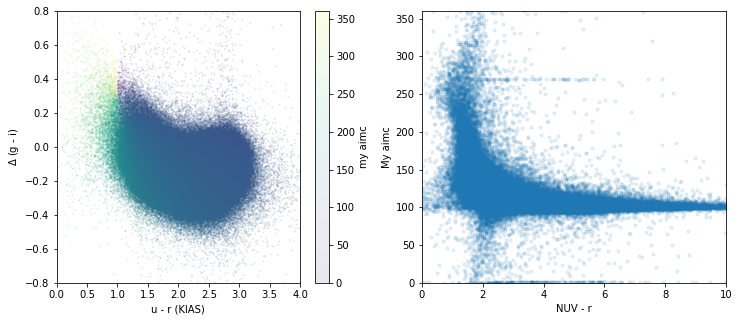

In [16]:
plt.figure(figsize=(12,5))



plt.subplot(121)

plt.scatter(galaxies['u_r_KIAS'], galaxies['cd'], s=1, c=galaxies['my_aimc'], alpha=0.1)

cbar = plt.colorbar()
cbar.ax.set_ylabel('my aimc')

plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')

plt.axis([0, 4, -0.8, 0.8])



plt.subplot(122)

plt.plot(galaxies['NUV_r'], galaxies['my_aimc'], '.', alpha=0.1)

#plt.hlines([45, 275], 0, 10, colors='r', linestyle='dotted')

#plt.vlines(5, 0, 165, colors='g', linestyle='dashed')

plt.axis([0, 10, 0, 360])

plt.xlabel('NUV - r')
plt.ylabel('My aimc');

# Define the GV

Split the galaxies up based on their location in the color - color gradient space (based on Park & Choi 2005 and Choi et al. 2010), their inverse concentration index, and their `my_aimc_vertical` value.

* RS: normal early-type galaxies
* GV: 
  * blue early-type galaxies
  * normal late-type galaxies within the bounds of early-types with `conx1` > some value
  * normal late-type galaxies with `my_aimc` < 110
* BC: normal late-type galaxies with `my_aimc` > 110

#### Magnitude bins

In [17]:
boolean_14p5_16 = galaxies['prmag'] < 16
boolean_16_16p5 = np.logical_and(galaxies['prmag'] >= 16, galaxies['prmag'] < 16.5)
boolean_16p5_17 = np.logical_and(galaxies['prmag'] >= 16.5, galaxies['prmag'] < 17)
boolean_17_17p5 = galaxies['prmag'] >= 17

### Define the `conx1` limit as the intersection of the skew-normal distribution sum

\begin{equation}
  f(x; \alpha, \mu_\alpha, \sigma_\alpha, \xi_\alpha, \beta, \mu_\beta, \sigma_\beta, \xi_\beta) = \alpha \phi(z_\alpha) \Phi(\xi_\alpha z_\alpha) + \beta \phi(z_\beta) \Phi(\xi_\beta z_\beta)
\end{equation}

where $z = (x - \mu)/\sigma$, $\phi$ is the standard normal distribution, and $\Phi$ is the standard normal CDF.

In [18]:
from skewNorms_fit import skewNorms2, skewNorms2_fit, skewNorms2_diff

from scipy.stats import skewnorm

In [19]:
cinv_bins = np.arange(0.2, 0.6, 0.005)
cinv_centers = 0.5*(cinv_bins[1:] + cinv_bins[:-1])

color_boolean = np.logical_and(galaxies['u_r_KIAS'] > 2.5, galaxies['u_r_KIAS'] < 3.5)

##### Brightest galaxies

In [34]:
param_bounds = [[10., 3000.], # a ......... skew normal 1 amplitude
                [0.25, 0.35], # mu_a ...... skew normal 1 mean
                [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],  # skew_a .... skew normal 1 skew
                [1., 1000.],  # b ......... skew normal 2 amplitude
                [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]]  # skew_b .... skew normal 2 skew

In [35]:
#dist_bright,_ = np.histogram(galaxies['conx1'][boolean_14p5_16 & color_boolean], bins=cinv_bins)
dist_bright,_ = np.histogram(galaxies['conx1'][boolean_14p5_16], bins=cinv_bins)

bestfit = skewNorms2_fit(cinv_centers, dist_bright, param_bounds)

print(bestfit)

      fun: 482.42972645108506
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.92219279e-04,  8.58511840e-01,  1.45433887e-01,  2.66027202e-03,
        2.84216869e-05,  1.05222852e-01, -7.67329312e-02,  2.27373677e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2106
      nit: 165
     njev: 234
   status: 0
  success: True
        x: array([ 1.67289064e+02,  2.90195156e-01,  5.05803476e-02,  5.30651727e+00,
        1.61268498e+02,  5.07802374e-01,  8.55864567e-02, -2.12273571e+00])


##### $16 < m_r < 16.5$

In [36]:
param_bounds = [[10., 3000.], # a ......... skew normal 1 amplitude
                [0.25, 0.35], # mu_a ...... skew normal 1 mean
                [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                [-30., 30.],  # skew_a .... skew normal 1 skew
                [1., 1000.],  # b ......... skew normal 2 amplitude
                [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                [-20., 20.]]  # skew_b .... skew normal 2 skew

In [37]:
#dist_16_16p5,_ = np.histogram(galaxies['conx1'][boolean_16_16p5 & color_boolean], bins=cinv_bins)
dist_16_16p5,_ = np.histogram(galaxies['conx1'][boolean_16_16p5], bins=cinv_bins)

bestfit_16_16p5 = skewNorms2_fit(cinv_centers, dist_16_16p5, param_bounds)

print(bestfit_16_16p5)

      fun: 423.09101635459837
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.13908437e-04, -2.60655497e-01,  1.84871851e-01, -1.79625205e-03,
       -1.63708916e-03, -8.41225751e-01, -1.66267000e-02, -1.16870070e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2205
      nit: 162
     njev: 245
   status: 0
  success: True
        x: array([ 1.61873767e+02,  2.93497570e-01,  5.71404627e-02,  5.71130736e+00,
        1.43937463e+02,  5.10641405e-01,  8.03036753e-02, -2.10360289e+00])


$16.5 < m_r < 17$

In [39]:
param_bounds_16p5_17 = [[10., 3000.], # a ......... skew normal 1 amplitude
                        [0.25, 0.35], # mu_a ...... skew normal 1 mean
                        [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                        [-30., 30.],  # skew_a .... skew normal 1 skew
                        [1., 1000.],  # b ......... skew normal 2 amplitude
                        [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                        [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                        [0., 20.]]    # skew_b .... skew normal 2 skew

In [40]:
#dist_16p5_17,_ = np.histogram(galaxies['conx1'][boolean_16p5_17 & color_boolean], bins=cinv_bins)
dist_16p5_17,_ = np.histogram(galaxies['conx1'][boolean_16p5_17], bins=cinv_bins)

bestfit_16p5_17 = skewNorms2_fit(cinv_centers, dist_16p5_17, param_bounds_16p5_17)

print(bestfit_16p5_17)

      fun: 748.606711178554
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.21689158e-03,  3.37544179e+00,  3.49541551e+00, -5.18411983e-02,
       -4.55883858e-03, -1.07769665e+01, -1.47333822e+01, -3.61683306e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1503
      nit: 108
     njev: 167
   status: 0
  success: True
        x: array([3.25088575e+02, 2.97945235e-01, 7.16952423e-02, 5.27222148e+00,
       2.05391806e+02, 4.70783177e-01, 4.32686518e-02, 4.24688924e-03])


##### Faint galaxies

In [26]:
param_bounds_faint = [[10., 3000.], # a ......... skew normal 1 amplitude
                      [0.25, 0.4],  # mu_a ...... skew normal 1 mean
                      [0.01, 3.0],  # sigma_a ... skew normal 1 standard deviation
                      [-30., 30.],  # skew_a .... skew normal 1 skew
                      [1., 1000.],  # b ......... skew normal 2 amplitude
                      [0.35, 0.6],  # mu_b ...... skew normal 2 mean
                      [0.01, 3.0],  # sigma_b ... skew normal 2 standard deviation
                      [-20., 20.]]  # skew_b .... skew normal 2 skew

In [29]:
#dist_faint,_ = np.histogram(galaxies['conx1'][boolean_17_17p5 & color_boolean], bins=cinv_bins)
dist_faint,_ = np.histogram(galaxies['conx1'][boolean_17_17p5], bins=cinv_bins)

bestfit_faint = skewNorms2_fit(cinv_centers, dist_faint, param_bounds_faint)

print(bestfit_faint)

      fun: 387.37300870872696
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.22959039e-03,  1.55602038e+01,  3.53166456e+00, -4.00177671e-03,
       -6.79846750e-03, -6.01000349e+00, -1.74210300e+00, -1.05148957e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1449
      nit: 124
     njev: 161
   status: 0
  success: True
        x: array([ 7.56133088e+02,  3.06070711e-01,  8.02282759e-02,  5.15755749e+00,
        6.00796632e+02,  5.18456805e-01,  7.76569975e-02, -2.40271858e+00])


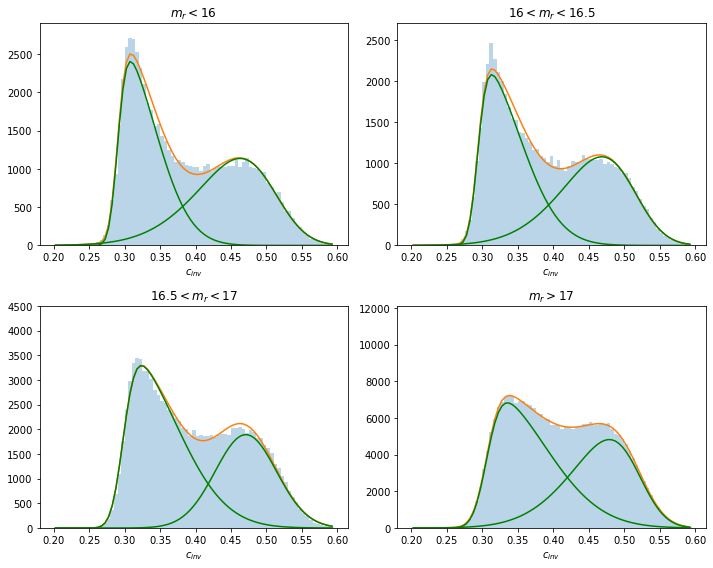

In [68]:
plt.figure(figsize=(10,8), tight_layout=True)

################################################################################
# Brightest galaxies
#-------------------------------------------------------------------------------
plt.subplot(221)

#plt.hist(galaxies['conx1'][boolean_14p5_16 & color_boolean], 
plt.hist(galaxies['conx1'][boolean_14p5_16], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit.x[0]*skewnorm.pdf(cinv_centers, bestfit.x[3], loc=bestfit.x[1], scale=bestfit.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit.x[4]*skewnorm.pdf(cinv_centers, bestfit.x[7], loc=bestfit.x[5], scale=bestfit.x[6]), 
        'g')

#plt.plot(cinv_centers,
#         bestfit.x[0]*norm.pdf(cinv_centers, loc=bestfit.x[1], scale=bestfit.x[2]), 
#         'r')
#plt.vlines(bestfit.x[1] + 2*bestfit.x[2], 0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2900)

plt.title('$m_r < 16$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16 < mr < 16.5
#-------------------------------------------------------------------------------
plt.subplot(222)

#plt.hist(galaxies['conx1'][boolean_16_16p5 & color_boolean], 
plt.hist(galaxies['conx1'][boolean_16_16p5], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16_16p5.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16_16p5.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[3], 
                                           loc=bestfit_16_16p5.x[1], 
                                           scale=bestfit_16_16p5.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16_16p5.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16_16p5.x[7], 
                                           loc=bestfit_16_16p5.x[5], 
                                           scale=bestfit_16_16p5.x[6]), 
        'g')

#plt.vlines(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2], 
#           0, 3000, colors='r', linestyle='dotted')

plt.ylim(ymax=2700)

plt.title('$16 < m_r < 16.5$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# 16.5 < mr < 17
#-------------------------------------------------------------------------------
plt.subplot(223)

#plt.hist(galaxies['conx1'][boolean_16p5_17 & color_boolean], 
plt.hist(galaxies['conx1'][boolean_16p5_17], 
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_16p5_17.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_16p5_17.x[0]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[3], 
                                           loc=bestfit_16p5_17.x[1], 
                                           scale=bestfit_16p5_17.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_16p5_17.x[4]*skewnorm.pdf(cinv_centers, 
                                           bestfit_16p5_17.x[7], 
                                           loc=bestfit_16p5_17.x[5], 
                                           scale=bestfit_16p5_17.x[6]), 
        'g')

#plt.vlines(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2], 
#           0, 4500, colors='r', linestyle='dotted')

plt.ylim(ymax=4500)

plt.title('$16.5 < m_r < 17$')
plt.xlabel('$c_{inv}$')
################################################################################


################################################################################
# Faintest galaxies
#-------------------------------------------------------------------------------
plt.subplot(224)

#plt.hist(galaxies['conx1'][boolean_17_17p5 & color_boolean], 
plt.hist(galaxies['conx1'][boolean_17_17p5],
         bins=cinv_bins, 
         alpha=0.3)

plt.plot(cinv_centers, skewNorms2(bestfit_faint.x, cinv_centers))
plt.plot(cinv_centers, 
         bestfit_faint.x[0]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[3], 
                                         loc=bestfit_faint.x[1], 
                                         scale=bestfit_faint.x[2]), 
        'g')
plt.plot(cinv_centers,
         bestfit_faint.x[4]*skewnorm.pdf(cinv_centers, 
                                         bestfit_faint.x[7], 
                                         loc=bestfit_faint.x[5], 
                                         scale=bestfit_faint.x[6]), 
        'g')

#plt.vlines(bestfit_faint.x[1] + 2*bestfit_faint.x[2], 
#           0, 12100, colors='r', linestyle='dotted')

plt.ylim(ymax=12100)

plt.title('$m_r > 17$')
plt.xlabel('$c_{inv}$');
################################################################################

### $c_\text{inv}$ cut

We implement a cut on $c_\text{inv}$ to filter normal early-type galaxies from normal late-type galaxies which fall within the Park05 bounds defining normal early-type galaxies.

Instead of using fixed values (based on magnitude bins) as done in Park05, we will use the point of intersection between the two skew normal functions fit to the data.

In [42]:
from scipy.optimize import root_scalar

##### Bright galaxies

In [43]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit.x[1] + 2*bestfit.x[2]))

print(rootResults)

cinv_bright = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.38193651493907566


##### $16 < m_r < 16.5$

In [44]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16_16p5.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit_16_16p5.x[1] + 2*bestfit_16_16p5.x[2]))

print(rootResults)

cinv_16_16p5 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.3933215314631074


##### $16.5 < m_r < 17$

In [45]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_16p5_17.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit_16p5_17.x[1] + 2*bestfit_16p5_17.x[2]))

print(rootResults)

cinv_16p5_17 = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.41787496786297906


##### Faint galaxies

In [46]:
rootResults = root_scalar(skewNorms2_diff, 
                          args=bestfit_faint.x, 
                          bracket=[0.35, 0.45], 
                          x0=(bestfit_faint.x[1] + 2*bestfit_faint.x[2]))

print(rootResults)

cinv_faint = rootResults.root

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.4198220684190696


## Morphological class
Based on the morphological classification of Park & Choi (2005)

#### Early-type

In [47]:
early_boolean1 = np.logical_and(galaxies['u_r_KIAS'] > 1, galaxies['cd'] > 0.3)

early_boolean2_14p5_16 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1, 
                                                galaxies['u_r_KIAS'] <= 2.6, 
                                                galaxies['cd'] > -0.28125*galaxies['u_r_KIAS'] + 0.58125))
early_boolean2_16_17 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                              galaxies['u_r_KIAS'] <= 2.65,
                                              galaxies['cd'] > -0.290909*galaxies['u_r_KIAS'] + 0.590909))
early_boolean2_17_17p5 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1,
                                                galaxies['u_r_KIAS'] <= 2.7,
                                                galaxies['cd'] > -0.28236*galaxies['u_r_KIAS'] + 0.582353))

early_boolean3_14p5_16 = np.logical_and(galaxies['u_r_KIAS'] > 2.60, galaxies['cd'] > -0.15)
early_boolean3_16_16p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, galaxies['cd'] > -0.18)
early_boolean3_16p5_17 = np.logical_and(galaxies['u_r_KIAS'] > 2.65, 
                                        galaxies['cd'] > -(0.07/0.85)*galaxies['u_r_KIAS'] + (-0.25 + (0.07*3.5/0.85)))
early_boolean3_17_17p5 = np.logical_and(galaxies['u_r_KIAS'] > 2.70, 
                                        galaxies['cd'] > -0.2125*galaxies['u_r_KIAS'] + 0.39375)

early_boolean_14p5_16_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_14p5_16, 
                                                   early_boolean3_14p5_16))
early_boolean_16_16p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16_16p5))
early_boolean_16p5_17_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_16_17, 
                                                   early_boolean3_16p5_17))
early_boolean_17_17p5_area = np.logical_or.reduce((early_boolean1, 
                                                   early_boolean2_17_17p5, 
                                                   early_boolean3_17_17p5))

# Require early-type galaxies to have inverse concentration indices smaller 
# than some value
early_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                       galaxies['conx1'] < cinv_bright)
early_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                       galaxies['conx1'] < cinv_16_16p5)
early_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                       galaxies['conx1'] < cinv_16p5_17)
early_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                       galaxies['conx1'] < cinv_faint)

# Galaxies that would normally have become late-types because of the above 
# restriction on cinv (conx1) are instead being classified as GV galaxies
gv_boolean_14p5_16 = np.logical_and(early_boolean_14p5_16_area, 
                                    galaxies['conx1'] >= cinv_bright)
gv_boolean_16_16p5 = np.logical_and(early_boolean_16_16p5_area, 
                                    galaxies['conx1'] >= cinv_16_16p5)
gv_boolean_16p5_17 = np.logical_and(early_boolean_16p5_17_area, 
                                    galaxies['conx1'] >= cinv_16p5_17)
gv_boolean_17_17p5 = np.logical_and(early_boolean_17_17p5_area, 
                                    galaxies['conx1'] >= cinv_faint)

#### Late type

Note that these galaxies contain those already assigned to the GV.

In [48]:
late_boolean_14p5_16 = np.logical_not(early_boolean_14p5_16)
late_boolean_16_16p5 = np.logical_not(early_boolean_16_16p5)
late_boolean_16p5_17 = np.logical_not(early_boolean_16p5_17)
late_boolean_17_17p5 = np.logical_not(early_boolean_17_17p5)

In [49]:
early_galaxies = vstack([galaxies[np.logical_and(boolean_14p5_16, early_boolean_14p5_16)], 
                         galaxies[np.logical_and(boolean_16_16p5, early_boolean_16_16p5)],
                         galaxies[np.logical_and(boolean_16p5_17, early_boolean_16p5_17)],
                         galaxies[np.logical_and(boolean_17_17p5, early_boolean_17_17p5)]])

late_galaxies_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, late_boolean_14p5_16),
                                              np.logical_and(boolean_16_16p5, late_boolean_16_16p5),
                                              np.logical_and(boolean_16p5_17, late_boolean_16p5_17),
                                              np.logical_and(boolean_17_17p5, late_boolean_17_17p5)))

In [50]:
gv_early_boolean = np.logical_or.reduce((np.logical_and(boolean_14p5_16, gv_boolean_14p5_16), 
                                         np.logical_and(boolean_16_16p5, gv_boolean_16_16p5), 
                                         np.logical_and(boolean_16p5_17, gv_boolean_16p5_17), 
                                         np.logical_and(boolean_17_17p5, gv_boolean_17_17p5)))

## Morphologial type
Based on the classification by Choi et al. (2010)

#### Normal late type

In [51]:
normal_late_boolean1 = np.logical_and.reduce((galaxies['u_r_KIAS'] > 1.8,
                                              galaxies['u_r_KIAS'] < 3.5,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 0.5))
normal_late_boolean2 = np.logical_and.reduce((galaxies['u_r_KIAS'] <= 1.8,
                                              galaxies['cd'] > -0.7,
                                              galaxies['cd'] < 1))

normal_late_boolean = np.logical_and(late_galaxies_boolean, 
                                     np.logical_or(normal_late_boolean1, normal_late_boolean2))

In [52]:
gv_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] <= 110, 
                                                np.logical_not(gv_early_boolean)))

bc_normal_late_boolean = np.logical_and.reduce((normal_late_boolean, 
                                                galaxies['my_aimc'] > 110, 
                                                np.logical_not(gv_early_boolean)))

#### Normal early type

In [53]:
normal_early_boolean = np.logical_and.reduce((early_galaxies['u_r_KIAS'] > 2.5,
                                              early_galaxies['u_r_KIAS'] < 3.5,
                                              early_galaxies['cd'] > -0.7, 
                                              early_galaxies['cd'] < 1))

#### Blue early type

In [54]:
blue_early_boolean = np.logical_and.reduce((early_galaxies['u_r_KIAS'] < 2.5,
                                            early_galaxies['cd'] > -0.7,
                                            early_galaxies['cd'] < 1))

In [55]:
normal_late_galaxies = galaxies[normal_late_boolean]
normal_early_galaxies = early_galaxies[normal_early_boolean]
blue_early_galaxies = early_galaxies[blue_early_boolean]

In [56]:
RS_galaxies = early_galaxies[normal_early_boolean]

GV_galaxies = vstack([blue_early_galaxies, 
                      galaxies[gv_early_boolean], 
                      galaxies[gv_normal_late_boolean]])

BC_galaxies = galaxies[bc_normal_late_boolean]

Check to make sure that there are no galaxies in more than one category.

In [57]:
################################################################################
# RS - GV overlap
#-------------------------------------------------------------------------------
rs_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in RS_galaxies['index']:
        rs_gv_overlap += 1
    
print('Overlap between RS and GV:', rs_gv_overlap)
################################################################################

Overlap between RS and GV: 0


In [58]:
################################################################################
# RS - BC overlap
#-------------------------------------------------------------------------------
rs_bc_overlap = 0

for i in range(len(RS_galaxies)):
    if RS_galaxies['index'][i] in BC_galaxies['index']:
        rs_bc_overlap += 1
    
print('Overlap between RS and BC:', rs_bc_overlap)
################################################################################

Overlap between RS and BC: 0


In [59]:
################################################################################
# BC - GV overlap
#-------------------------------------------------------------------------------
bc_gv_overlap = 0

for i in range(len(GV_galaxies)):
    if GV_galaxies['index'][i] in BC_galaxies['index']:
        bc_gv_overlap += 1
    
print('Overlap between BC and GV:', bc_gv_overlap)
################################################################################

Overlap between BC and GV: 0


## Color distribution

In [60]:
ur_bins = np.linspace(0,4.5,100)
NUVr_bins = np.linspace(0,10,100)

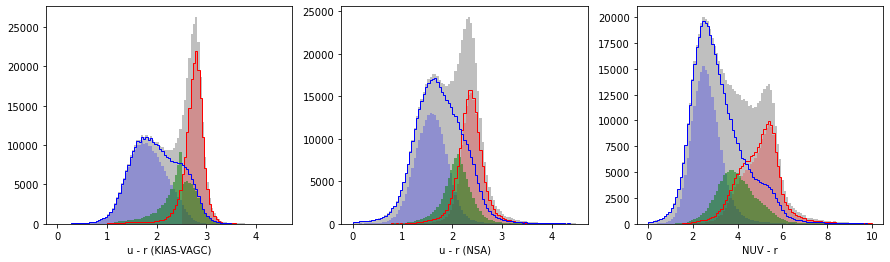

In [61]:
plt.figure(figsize=(15,4))

plt.subplot(131)

plt.hist(galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')




plt.subplot(132)

plt.hist(galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'], bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean], bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')




plt.subplot(133)

plt.hist(galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'], bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean], bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r');

There is a strange discontinuity in the GV population at $u - r = 2.5$.  It is most apparent in the KIAS-VAGC $u-r$ distribution, not the $u-r$ in the NSA.  This corresponds to a sharp cut in the RS at $u-r = 2.5$ as well, and is a result of the criteria separating the blue early types from the normal early types.

8/10/22: There is still a blue "bump" in the RS distribution in (NUV - r).  Is it becasue there are too many galaxies that have been shifted from the RS to the GV, or have not enough been moved from the RS to the GV?

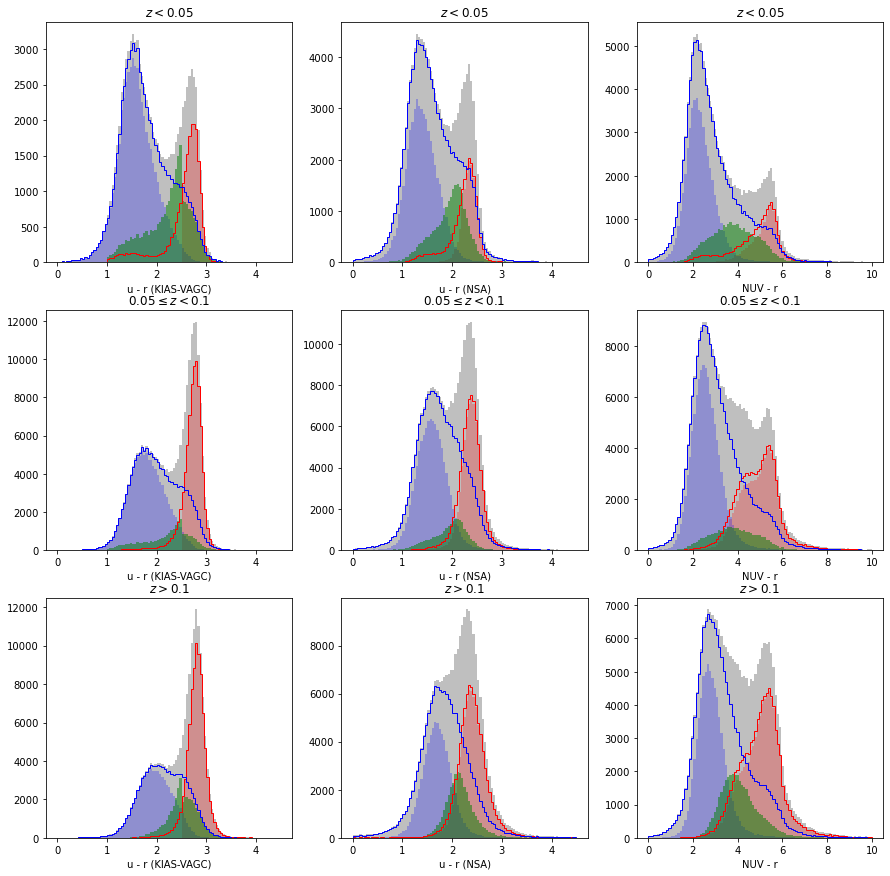

In [67]:
plt.figure(figsize=(15,15))

plt.subplot(331)

plt.hist(galaxies['u_r_KIAS'][galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][early_galaxies['Z'] < 0.05], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$z < 0.05$')




plt.subplot(332)

plt.hist(galaxies['u_r'][galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][RS_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][BC_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][GV_galaxies['Z'] < 0.05], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][early_galaxies['Z'] < 0.05], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$z < 0.05$')




plt.subplot(333)

plt.hist(galaxies['NUV_r'][galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][RS_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][BC_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][GV_galaxies['Z'] < 0.05], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][early_galaxies['Z'] < 0.05], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] < 0.05)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$z < 0.05$')




plt.subplot(334)

plt.hist(galaxies['u_r_KIAS'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(335)

plt.hist(galaxies['u_r'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(336)

plt.hist(galaxies['NUV_r'][(galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][(RS_galaxies['Z'] >= 0.05) & (RS_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][(BC_galaxies['Z'] >= 0.05) & (BC_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][(GV_galaxies['Z'] < 0.05) & (GV_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][(early_galaxies['Z'] >= 0.05) & (early_galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] >= 0.05) & (galaxies['Z'] < 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$0.05 \leq z < 0.1$')




plt.subplot(337)

plt.hist(galaxies['u_r_KIAS'][galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r_KIAS'][RS_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r_KIAS'][BC_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r_KIAS'][GV_galaxies['Z'] >= 0.1], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r_KIAS'][early_galaxies['Z'] >= 0.1], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r_KIAS'][late_galaxies_boolean & (galaxies['Z'] >= 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (KIAS-VAGC)')

plt.title('$z > 0.1$')




plt.subplot(338)

plt.hist(galaxies['u_r'][galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['u_r'][RS_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['u_r'][BC_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['u_r'][GV_galaxies['Z'] > 0.1], bins=ur_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['u_r'][early_galaxies['Z'] > 0.1], 
         bins=ur_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['u_r'][late_galaxies_boolean & (galaxies['Z'] > 0.1)], 
         bins=ur_bins, histtype='step', edgecolor='b')

plt.xlabel('u - r (NSA)')

plt.title('$z > 0.1$')




plt.subplot(339)

plt.hist(galaxies['NUV_r'][galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='k')

plt.hist(RS_galaxies['NUV_r'][RS_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='r')
plt.hist(BC_galaxies['NUV_r'][BC_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.25, facecolor='b')
plt.hist(GV_galaxies['NUV_r'][GV_galaxies['Z'] > 0.1], bins=NUVr_bins, alpha=0.5, facecolor='g')

plt.hist(early_galaxies['NUV_r'][early_galaxies['Z'] > 0.1], 
         bins=NUVr_bins, histtype='step', edgecolor='r')
plt.hist(galaxies['NUV_r'][late_galaxies_boolean & (galaxies['Z'] > 0.1)], 
         bins=NUVr_bins, histtype='step', edgecolor='b')

plt.xlabel('NUV - r')

plt.title('$z > 0.1$');

For $z < 0.05$, it looks like the GV is a little too wide $\to$ change where `aimc` is defined from?

For $0.05 \leq z < 0.1$, the blue bump in the RS is **very** apparent.  The GV is also really small here.

For $z > 0.1$, the blue bump of the RS is greatly reduced, but still there.

## CMDs

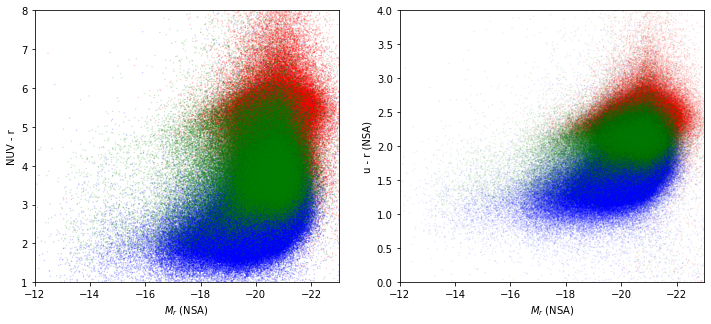

In [64]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.scatter(RS_galaxies['ELPETRO_ABSMAG'][:,4], RS_galaxies['NUV_r'], s=2, c='r', alpha=0.2, 
            edgecolors='none')
plt.scatter(BC_galaxies['ELPETRO_ABSMAG'][:,4], BC_galaxies['NUV_r'], s=2, c='b', alpha=0.2, 
            edgecolors='none')
plt.scatter(GV_galaxies['ELPETRO_ABSMAG'][:,4], GV_galaxies['NUV_r'], s=2, c='g', alpha=0.2,
            edgecolors='none')
plt.xlabel('$M_r$ (NSA)')
plt.ylabel('NUV - r')
plt.axis([-12, -23, 1, 8])

plt.subplot(122)
plt.scatter(RS_galaxies['ELPETRO_ABSMAG'][:,4], RS_galaxies['u_r'], s=2, c='r', alpha=0.1, 
            edgecolors='none')
plt.scatter(BC_galaxies['ELPETRO_ABSMAG'][:,4], BC_galaxies['u_r'], s=2, c='b', alpha=0.1, 
            edgecolors='none')
plt.scatter(GV_galaxies['ELPETRO_ABSMAG'][:,4], GV_galaxies['u_r'], s=2, c='g', alpha=0.1,
            edgecolors='none')
plt.xlabel('$M_r$ (NSA)')
plt.ylabel('u - r (NSA)')
plt.axis([-12, -23, 0, 4]);

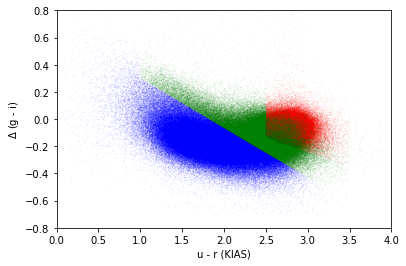

In [66]:
plt.figure()

plt.scatter(RS_galaxies['u_r_KIAS'], 
            RS_galaxies['cd'], 
            s=1, 
            c='r',
            #c=RS_galaxies['NUV_r'], 
            #cmap=cm.RdBu_r, 
            edgecolors='none', 
            alpha=0.1, 
            label='Red sequence')
#cbar = plt.colorbar(label='NUV - r')
#plt.clim(1,8)
#cbar.ax.set_ylabel('NUV - r')

plt.scatter(BC_galaxies['u_r_KIAS'], BC_galaxies['cd'], s=1, c='b', alpha=0.1, edgecolors='none', 
            label='Blue cloud')

plt.scatter(GV_galaxies['u_r_KIAS'], GV_galaxies['cd'], s=1, c='g', alpha=0.1, edgecolors='none', 
            label='Green valley')

plt.xlabel('u - r (KIAS)')
plt.ylabel('$\Delta$ (g - i)')

#plt.legend()

plt.axis([0, 4, -0.8, 0.8]);